# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../traffic-signs-data/train.p'
testing_file = '../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

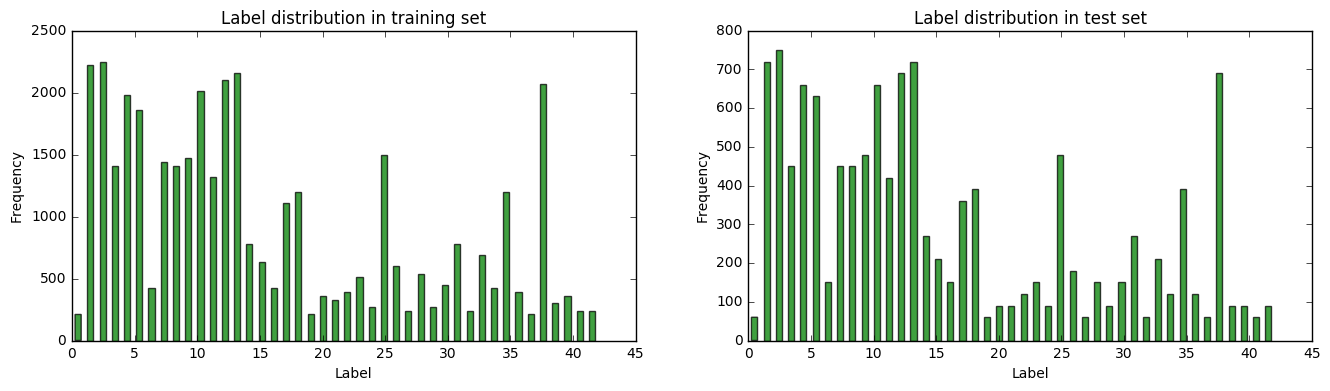

Some example images in training set...


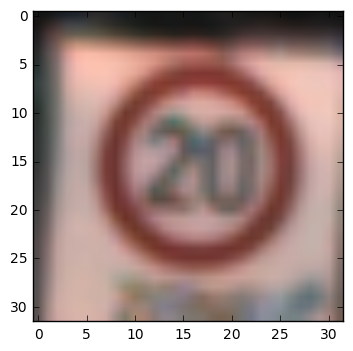

Speed limit (20km/h)
---------------


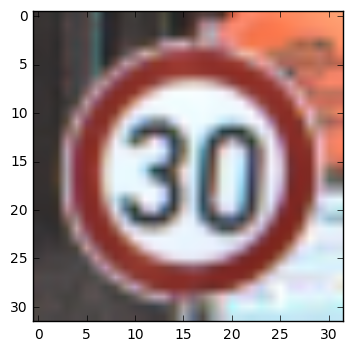

Speed limit (30km/h)
---------------


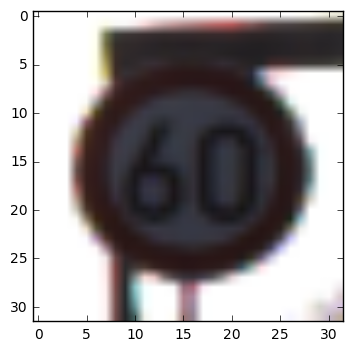

Speed limit (60km/h)
---------------


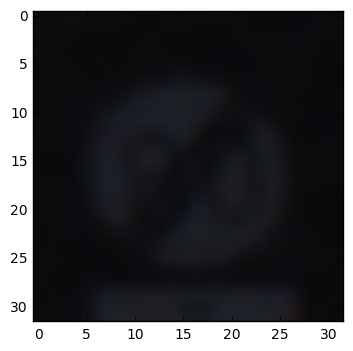

End of speed limit (80km/h)
---------------


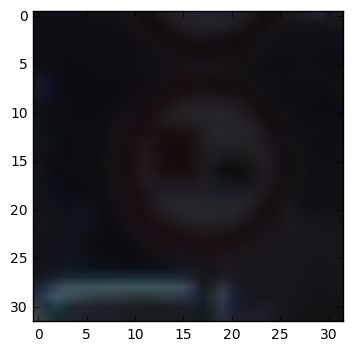

No passing for vehicles over 3.5 metric tons
---------------


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# distribution of classes in training and sets
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))

ax0.hist(y_train, n_classes, histtype='bar', facecolor='g', alpha=0.75, rwidth=0.5)
ax0.set_title('Label distribution in training set')
ax0.set_xlabel('Label')
ax0.set_ylabel('Frequency')

ax1.hist(y_test, n_classes, histtype='bar', facecolor='g', alpha=0.75, rwidth=0.5)
ax1.set_title('Label distribution in test set')
ax1.set_xlabel('Label')
ax1.set_ylabel('Frequency')

plt.show()

# read label codes from csv
import pandas as pd
sign_names_df = pd.read_csv('signnames.csv')
classIdToSignNameDict = sign_names_df.set_index('ClassId').to_dict()['SignName']

# show a few of images
def show_image_and_label(idx):
    plt.imshow(X_train[idx])
    plt.show()
    print(classIdToSignNameDict[y_train[idx]])
    print('---------------')
    
print("Some example images in training set...")
show_image_and_label(100)
show_image_and_label(2000)
show_image_and_label(5000)
show_image_and_label(10000)
show_image_and_label(15000)

### SOME IMAGES ARE VERY DARK AND HARD FOR HUMAN EYE TO DECIPHER. HOW DID WE GET A LABEL FOR THESE?
### TRY OTHER NORMALIZATIONS TO ENHANCE DARK IMAGE

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle

# normalize images
# make mean 0 and values range [-0.5, 0.5]
def normalize_images(imgs):
    return (imgs - 128.) / 255.

# inverse of the above method
def reconstruct_image(normalized_image):
    return (normalized_image * 255.) - 128.

# reduce data to test on local machine
reduced_data_set_mode = False
if reduced_data_set_mode:
    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)
    X_train = X_train[:1000]
    X_test = X_test[:1000]
    y_train = y_train[:1000]
    y_test = y_test[:1000]

X_train_normalized = normalize_images(X_train)
X_test_normalized = normalize_images(X_test)

# one-hot encode labels will be done in tensor flow code

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I first normalized feature values to have a mean of 0 and very small sigma. This well conditioned data will help gradient descent reach minima quickly and reliably. Since RGB values all range from [0, 255], I applied a simple normalization of val = (val - 128 ) / 255. This will make the mean 0, and values range [-0.5, 0.5].

In [5]:
from sklearn.model_selection import train_test_split

### Generate data additional data (OPTIONAL!)
### dummy for now
generated_data_X = X_train_normalized[0:1]
generated_data_y = y_train[0:1]

### It looks like original training data is 75% of total data and test is 25%
### I am maintaining same distribution for generated dataset too
### split generated data into train and test - train 75%, test 25%
### NOTE that train_test_split method also shuffles data
generated_data_X_train, generated_data_X_test, generated_data_y_train, generated_data_y_test = train_test_split(
    generated_data_X,
    generated_data_y,
    test_size=0.25,
    random_state=832289)
print("Generated data shape = ", generated_data_X.shape)
print("Generated data train shape = ", generated_data_X_train.shape)
print("Generated data test shape = ", generated_data_X_test.shape)


### combine train data from dataset to generated. same with test
all_X_train = np.concatenate((X_train_normalized, generated_data_X_train))
all_X_test = np.concatenate((X_test_normalized, generated_data_X_test))
all_y_train = np.concatenate((y_train, generated_data_y_train))
all_y_test = np.concatenate((y_test, generated_data_y_test))

### and split the data into training/validation/testing sets here.
### split train into train (90%) and validation(10%)
### This will leave us in all with 
### train set at (0.9*0.75) 67.5%, 
### validation set at (0.1*0.75) 7.5% 
### and test set at 25% 
train_features, valid_features, train_labels, valid_labels = train_test_split(
    all_X_train,
    all_y_train,
    test_size=0.1,
    random_state=832289)
test_features = all_X_test
test_labels = all_y_test

print("Training examples shape =", train_features.shape)
print("Validation examples shape =", valid_features.shape)
print("Test examples shape =", test_features.shape)
print("Test labels shape =", test_labels.shape)

### Feel free to use as many code cells as needed.

Generated data shape =  (1, 32, 32, 3)
Generated data train shape =  (0, 32, 32, 3)
Generated data test shape =  (1, 32, 32, 3)
Training examples shape = (35288, 32, 32, 3)
Validation examples shape = (3921, 32, 32, 3)
Test examples shape = (12631, 32, 32, 3)
Test labels shape = (12631,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNetLikeArchitecture(x, mu, sigma, nclasses, keep_prob):    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 200. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 120. Output = 80.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 80), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(80))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    # Dropout layer
    fc3 = tf.nn.dropout(fc3, keep_prob)

    # Layer 6: Fully Connected. Input = 80. Output = nclasses.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(80, nclasses), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(nclasses))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from sklearn.utils import shuffle

### Hyperparameters - START
EPOCHS = 4
BATCH_SIZE = 256
# params for initial weights
MU = 0
SIGMA = 0.1
LEARNING_RATE = 0.05
### Hyperparameters - END

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = LeNetLikeArchitecture(x, mu=MU, sigma=SIGMA, nclasses=n_classes, keep_prob=keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

predictions = tf.argmax(logits, 1)
truth_labels = tf.argmax(one_hot_y, 1)
correct_prediction = tf.equal(predictions, truth_labels)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, batch_size):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_features)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(valid_features, valid_labels, BATCH_SIZE)
        if (i%2 == 0):
            print("EPOCH {} ...".format(i))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    model_path = saver.save(sess, 'model')    
    print("Model saved at path: ", model_path)


Training...
EPOCH 0 ...
Validation Accuracy = 0.481
EPOCH 2 ...
Validation Accuracy = 0.828
Model saved at path:  model


In [8]:
### test accuracy
with tf.Session() as sess:
    # Restore variables from disk.
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(test_features, test_labels, BATCH_SIZE)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.809


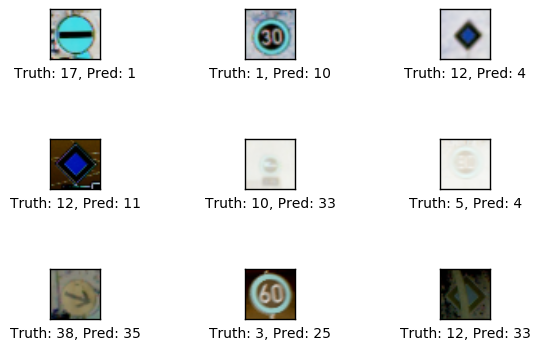

In [28]:
### print a few images and see performance on test set

nine_test_features = test_features[100:109]
nine_test_labels = test_labels[:9]

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    preds = predictions.eval(feed_dict={x: nine_test_features, y: nine_test_labels, keep_prob:1.0})

    assert len(nine_test_features) == len(preds) == 9

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=1.6, wspace=1.6)
    idx = 0
    for i, ax in enumerate(axes.flat):        
        reconstructed_image = reconstruct_image(ten_test_features[idx])
        ax.imshow(reconstructed_image)
        xlabel = "Truth: %d, Pred: %d"%(ten_test_labels[idx], preds[idx])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        idx = idx + 1

    plt.show()


Classes with less than 50% accuracy: 
0
3
19
20
21
23
24
27
29
30


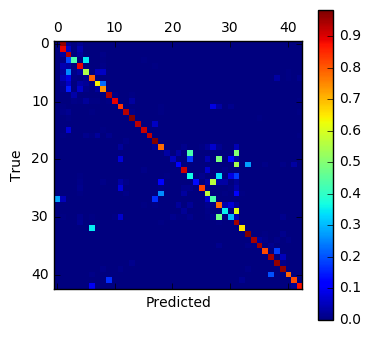

In [40]:
### confusion matrix
from sklearn.metrics import confusion_matrix

def normalize_by_row(arr):
    sum_along_rows = np.sum(arr, axis=1)
    sum_along_rows = sum_along_rows[:, np.newaxis]
    return arr/sum_along_rows

with tf.Session() as sess:
    # Restore variables from disk.
    loader = tf.train.import_meta_graph('model.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    preds = predictions.eval(feed_dict={x: test_features, y: test_labels, keep_prob:1.0})
    conf_matrix = confusion_matrix(test_labels, preds)
    
    conf_matrix = normalize_by_row(conf_matrix)

    plt.matshow(conf_matrix)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    print('Classes with less than 50% accuracy: ')
    for i in range(n_classes):
        acc = 
        if conf_matrix[i][i] < 0.5:
            print("%d - %f"%(i, conf_matrix[i][i]))


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.